In [151]:
import pandas as pd

df = pd.read_csv('dataset.csv')


DATA PREPROCESSING

In [152]:
# No electric engines
df.drop(['model','exterior_color','interior_color','engine','memory_seat'],axis=1, inplace=True)
df.dropna(subset=['transmission','engine_size'],inplace=True)

median_list = ['min_mpg','max_mpg','first_owner','damaged','personal_using']
for item in median_list:
    med = df[item].median()
    df[item].fillna(med, inplace = True)

df['price'] = df['price'].replace(['ot Priced'],0)
df['price'] = df['price'].replace([0],df['price'].median())


for columnName in df:
    mode = df[columnName].mode()
    df[columnName].fillna(mode, inplace=True)
    
df["price"] = df["price"].astype("float")


Certain categorical features have multiple unique values (>10), which may be resource consuming and hard for the model to cover different kinds of combinations. This step aims to reduce unique values who account for less than the threshold (this case 5% of all rows) and labels it as '[Column_Name]_RARE' unique value.

Source: https://github.com/danbochman/Fatality-Analysis-Reporting-System/blob/master/FARS%20Notebook%20-%20Completed%20-%20Handling%20Categorical%20Data.ipynb

In [153]:
tot_instances = df.shape[0]
threshold = tot_instances*0.005
print ('The minimum count threshold is: '+str(threshold))

# Apply the count threshold to all the categorical values
obj_columns = list(df.select_dtypes(include=['object']).columns)    # Get a list of all the columns' names with object dtype
obj_columns.remove('brand')                               # If you chose to keep rare classes
df = df.apply(lambda x: x.mask(x.map(x.value_counts())<threshold, 'RARE') if x.name in obj_columns else x)

The minimum count threshold is: 111.265


Perform one hot encoding on all values

In [154]:
df_encoded = df[obj_columns] 
df_encoded = pd.get_dummies(data=df, columns=obj_columns)

# Converts any boolean col dtypes into int
df_encoded = df_encoded *1


In [155]:
obj_columns.append('brand')
merged = pd.concat([df,df_encoded],axis='columns')
merged.drop(obj_columns, axis=1,inplace=True)


In [156]:
final_df = merged.drop(['transmission_10-Speed Automatic','fuel_type_Diesel',
                        'drivetrain_Rear-wheel Drive'],axis='columns')

# Removes Duplicates
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# Standardize data using min-max scaling
for column in final_df.columns:
    final_df[column] = (final_df[column] - final_df[column].min()) / (final_df[column].max() - final_df[column].min())



# final_df.to_csv('UsedCars_Processed.csv')

Price feature is seen to have many outliers which may skew or heavily affect model accuracy. Since price feature is understood to be labelled by users on cars.com, there might be some level of human error/bias. Thus it is necessary to address said outliers

<Axes: >

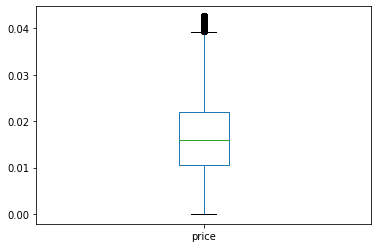

In [166]:
final_df.boxplot(column =['price'], grid = False)

In [158]:
# PRICE OUTLIERS

IQR_weight = final_df["price"].quantile(0.75) - final_df["price"].quantile(0.25)
UpperBound_weight = final_df["price"].quantile(0.75) + 1.5*IQR_weight
LowerBound_weight = 0 

final_df = final_df[final_df["price"] <= UpperBound_weight][final_df["price"] >= LowerBound_weight]

C:\Users\Ram\AppData\Local\Temp/ipykernel_20524/2325400625.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df = final_df[final_df["price"] <= UpperBound_weight][final_df["price"] >= LowerBound_weight]


Looked at the outliers for Year, Max_MPG, and Min_MPG. The outliers for these features were found to be realistic and exists in the current car industry (i.e. Certain car models and brands can have a max of 97 mpg). Thus the outliers for these features remain to be untouched.  


<Axes: >

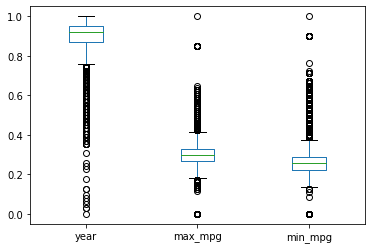

In [159]:

final_df.boxplot(column =['year','max_mpg','min_mpg'], grid = False)

In [160]:


# final_df.to_csv('UsedCars_Processed.csv')

MODEL CREATION

In [161]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression()

features = final_df.drop(['price'],axis=1)
target = final_df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0, test_size=0.2)

In [162]:
model.fit(X_train,y_train)

LinearRegression()

In [163]:
matr = model.predict(X_train)

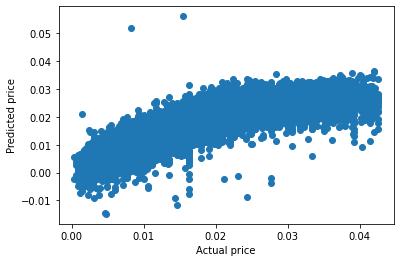

In [164]:
import matplotlib.pyplot as plt
plt.scatter(y_train, matr)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.show()

In [165]:
from sklearn.metrics import r2_score

r2_score(y_train,matr)

0.6658381446068447

In [167]:
model.score(X_test,y_test)

0.6700524319593099